# Code with explicit math imlpementation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
import time
import kagglehub
import json
from tqdm import tqdm
import os
from tensor_decompositions import compute_error, compute_error_normalized_by_species

In [2]:
reynolds_numbers = [8000]
paths = [f"sharmapushan/hydrogen-jet-{re}" for re in reynolds_numbers]
data_paths = [kagglehub.dataset_download(name) for name in paths]
data_path = data_paths[0]
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)
subsample_x, subsample_y = 5,5
Nx, Ny = metadata['global']['Nxyz']
n_snapshots = metadata['global']['snapshots'] - 1
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y

component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']
species_names = [cname[1:] for cname in component_names]
n_species = len(component_names)
molar_masses = {'YH': 1.0, 'YH2': 2.0, 'YO': 8.0, 'YO2': 16.0, 'YOH': 9.0, 'YH2O': 10.0, 'YHO2': 17.0, 'YH2O2': 18.0}
file_key_map = file_key_map = {'YH': 'YH filename', 'YH2': 'YH2 filename', 'YO': 'YO filename', 'YO2': 'YO2 filename',
                                'YOH': 'YOH filename', 'YH2O': 'YH2O filename', 'YHO2': 'YHO2 filename', 'YH2O2': 'YH2O2 filename'
}
Lx, Ly = 12.5, 15.6
print(f"Grid: {Nx}x{Ny}, Subsampled: {Nx_sub}x{Ny_sub}")
tensor_ = np.zeros((Ny_sub, Nx_sub, n_species, n_snapshots))

for t_idx in tqdm(range(n_snapshots)):
    for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
        filename_key = file_key_map[comp_name]
        filename = metadata['local'][t_idx][filename_key]
        data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
        molar_data = data / molar_masses[comp_name]
        tensor_[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]
print(tensor_.shape)
print("Data loading complete!")
tensor_combustion = tensor_[:, :, :, :]

# Create log-transformed tensor
epsilon = 1e-10
tensor_combustion_log = np.zeros_like(tensor_combustion)
for i in range(tensor_combustion.shape[2]):
    tensor_combustion_log[:, :, i, :] = np.log(np.maximum(tensor_combustion[:, :, i, :], epsilon))
print(f"Log tensor created with shape: {tensor_combustion_log.shape}")

Grid: 1600x2000, Subsampled: 320x400


100%|██████████| 200/200 [00:24<00:00,  8.08it/s]


(400, 320, 8, 200)
Data loading complete!
Log tensor created with shape: (400, 320, 8, 200)


In [3]:
def select_rank_by_ratio(array, varepsilon):
    sorted_array = np.sort(array)[::-1]
    total_energy = np.sum(sorted_array)
    cumulative_energy = np.cumsum(sorted_array)
    num_components = np.sum(cumulative_energy <= varepsilon * total_energy) + 1
    return min(num_components, len(array))

In [4]:
# Sequentially truncated HOSVD on log tensor
start_t = time.time()
factors_st = []
current_tensor = tensor_combustion_log.copy()

for mode in range(current_tensor.ndim):
    unfolded = tl.unfold(current_tensor, mode)
    g_matrix = unfolded @ unfolded.T
    eigenvalues, eigenvectors = np.linalg.eigh(g_matrix)
    eigenvalues = np.sqrt(np.abs(eigenvalues))
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    trunc_idx = select_rank_by_ratio(eigenvalues, 0.99)
    print(trunc_idx)
    U_trunc = eigenvectors[:, :trunc_idx].real
    current_tensor = tl.tenalg.mode_dot(current_tensor, U_trunc.T, mode)
    factors_st.append(U_trunc)
core_st = current_tensor
end_t = time.time()
st_time = end_t - start_t
print(f"stHOSVD computed in {st_time:.2f} seconds")
print(core_st.shape)

# Reconstruct in log space
reconstruction_st_log = tl.tenalg.multi_mode_dot(core_st, factors_st, [0,1,2,3])

# Transform back to original space
reconstruction_st = np.exp(reconstruction_st_log) - epsilon

print(np.allclose(reconstruction_st, tensor_combustion))
error_st = compute_error(tensor_combustion, reconstruction_st)
print(f"stHOSVD relative error: {error_st:.6f}")

84
65
7
161
stHOSVD computed in 1.25 seconds
(84, 65, 7, 161)
False
stHOSVD relative error: 0.043538


In [5]:
# Subsampled HOSVD (Gram matrix) on log tensor
start_t = time.time()
factors_sub = []

for mode in range(tensor_combustion_log.ndim):
    unfolded = tl.unfold(tensor_combustion_log[tuple(slice(None) if d == mode else slice(None, None, 2) for d in range(tensor_combustion_log.ndim))], mode)
    print(unfolded.shape)
    g_matrix = unfolded @ unfolded.T
    eigenvalues, eigenvectors = np.linalg.eigh(g_matrix)
    eigenvalues = np.sqrt(np.abs(eigenvalues))
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    trunc_idx = select_rank_by_ratio(eigenvalues, varepsilon=0.99)
    print(trunc_idx)
    U_trunc = eigenvectors[:, :trunc_idx].real
    factors_sub.append(U_trunc)
core_sub = tl.tenalg.multi_mode_dot(tensor_combustion_log, [f.T for f in factors_sub], modes=list(range(tensor_combustion_log.ndim)))
end_t = time.time()
sub_time = end_t - start_t
print(f"sub HOSVD computed in {sub_time:.2f} seconds")
print(f"Subsampled HOSVD computed in {sub_time:.2f} seconds")

reconstruction_sub_log = tl.tenalg.multi_mode_dot(core_sub, factors_sub, [0,1,2,3])

reconstruction_sub = np.exp(reconstruction_sub_log) - epsilon

print(np.allclose(reconstruction_sub, tensor_combustion))
error_sub = compute_error(tensor_combustion, reconstruction_sub)
print(f"Subsampled HOSVD relative error: {error_sub:.6f}")

(400, 64000)
74
(320, 80000)
65
(8, 3200000)
7
(200, 128000)
160
sub HOSVD computed in 1.79 seconds
Subsampled HOSVD computed in 1.79 seconds
False
Subsampled HOSVD relative error: 0.051311


In [6]:
start_t = time.time()
factors_sub = []

for mode in range(tensor_combustion_log.ndim):
    unfolded = tl.unfold(tensor_combustion_log[tuple(slice(None) if d == mode else slice(None, None, 2) for d in range(tensor_combustion_log.ndim))], mode)
    U, S, Vh = np.linalg.svd(unfolded, full_matrices=False)
    trunc_idx = select_rank_by_ratio(S, varepsilon=0.99)
    print(trunc_idx)
    U_trunc = U[:, :trunc_idx].real
    factors_sub.append(U_trunc)
core_sub = tl.tenalg.multi_mode_dot(tensor_combustion_log, [f.T for f in factors_sub], modes=list(range(tensor_combustion_log.ndim)))
end_t = time.time()
sub_time = end_t - start_t
print(f"sub HOSVD computed in {sub_time:.2f} seconds")
print(f"Subsampled HOSVD computed in {sub_time:.2f} seconds")

reconstruction_sub_log = tl.tenalg.multi_mode_dot(core_sub, factors_sub, [0,1,2,3])

reconstruction_sub = np.exp(reconstruction_sub_log) - epsilon

print(np.allclose(reconstruction_sub, tensor_combustion))
error_sub = compute_error(tensor_combustion, reconstruction_sub)
print(f"Subsampled HOSVD relative error: {error_sub:.6f}")

74
65
7
160
sub HOSVD computed in 9.05 seconds
Subsampled HOSVD computed in 9.05 seconds
False
Subsampled HOSVD relative error: 0.051311


# Generated Code

# Comparison: stHOSVD on Original vs Log Tensor

In [26]:
# Run stHOSVD on original tensor (tensor_combustion)
print("Running stHOSVD on original tensor...")
start_t = time.time()
factors_st_orig = []
current_tensor_orig = tensor_combustion.copy()
truncation_indices = []
for mode in range(current_tensor_orig.ndim):
    unfolded = tl.unfold(current_tensor_orig, mode)
    g_matrix = unfolded @ unfolded.T
    eigenvalues, eigenvectors = np.linalg.eigh(g_matrix)
    eigenvalues = np.sqrt(np.abs(eigenvalues))
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    trunc_idx = select_rank_by_ratio(eigenvalues, 0.999)
    truncation_indices.append(trunc_idx)
    print(f"Mode {mode}: rank = {trunc_idx}")
    U_trunc = eigenvectors[:, :trunc_idx].real
    current_tensor_orig = tl.tenalg.mode_dot(current_tensor_orig, U_trunc.T, mode)
    factors_st_orig.append(U_trunc)

core_st_orig = current_tensor_orig
end_t = time.time()
st_time_orig = end_t - start_t

# Reconstruct
reconstruction_st_orig = tl.tenalg.multi_mode_dot(core_st_orig, factors_st_orig, [0,1,2,3])
error_st_orig = compute_error(tensor_combustion, reconstruction_st_orig)

print(f"stHOSVD on original tensor computed in {st_time_orig:.2f} seconds")
print(f"Core shape: {core_st_orig.shape}")
print(f"Relative error: {error_st_orig:.6f}")
print()

# Run stHOSVD on log tensor (tensor_combustion_log) - rerun for comparison
print("Running stHOSVD on log tensor...")
start_t = time.time()
factors_st_log = []
current_tensor_log = tensor_combustion_log.copy()

for mode in range(current_tensor_log.ndim):
    unfolded = tl.unfold(current_tensor_log, mode)
    g_matrix = unfolded @ unfolded.T
    eigenvalues, eigenvectors = np.linalg.eigh(g_matrix)
    eigenvalues = np.sqrt(np.abs(eigenvalues))
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    trunc_idx = select_rank_by_ratio(eigenvalues, 0.999)
    print(f"Mode {mode}: rank = {trunc_idx}")
    U_trunc = eigenvectors[:, :trunc_idx].real
    current_tensor_log = tl.tenalg.mode_dot(current_tensor_log, U_trunc.T, mode)
    factors_st_log.append(U_trunc)

core_st_log = current_tensor_log
end_t = time.time()
st_time_log = end_t - start_t

# Reconstruct in log space and transform back
reconstruction_st_log_space = tl.tenalg.multi_mode_dot(core_st_log, factors_st_log, [0,1,2,3])
reconstruction_st_log = np.exp(reconstruction_st_log_space) 
error_st_log = compute_error(tensor_combustion, reconstruction_st_log)

print(f"stHOSVD on log tensor computed in {st_time_log:.2f} seconds")
print(f"Core shape: {core_st_log.shape}")
print(f"Relative error: {error_st_log:.6f}")

Running stHOSVD on original tensor...
Mode 0: rank = 167
Mode 1: rank = 79
Mode 2: rank = 6
Mode 3: rank = 199
stHOSVD on original tensor computed in 2.23 seconds
Core shape: (167, 79, 6, 199)
Relative error: 0.002161

Running stHOSVD on log tensor...
Mode 0: rank = 257
Mode 1: rank = 169
Mode 2: rank = 8
Mode 3: rank = 196
stHOSVD on log tensor computed in 3.39 seconds
Core shape: (257, 169, 8, 196)
Relative error: 0.006637



NORMALIZED ERROR BY SPECIES (RMSE / Mean per species)

Species    Original Tensor      Log Tensor           Improvement    
--------------------------------------------------------------------------------
H          0.011368             0.014126                    -24.26%
H2         0.006124             0.018691                   -205.19%
O          0.078661             0.003949                    +94.98%
O2         0.001505             0.000573                    +61.89%
OH         0.078986             0.009949                    +87.40%
H2O        0.009054             0.041471                   -358.04%
HO2        2.292375             0.038411                    +98.32%
H2O2       1.372445             0.013409                    +99.02%
--------------------------------------------------------------------------------
OVERALL    0.481315             0.017572                    +96.35%


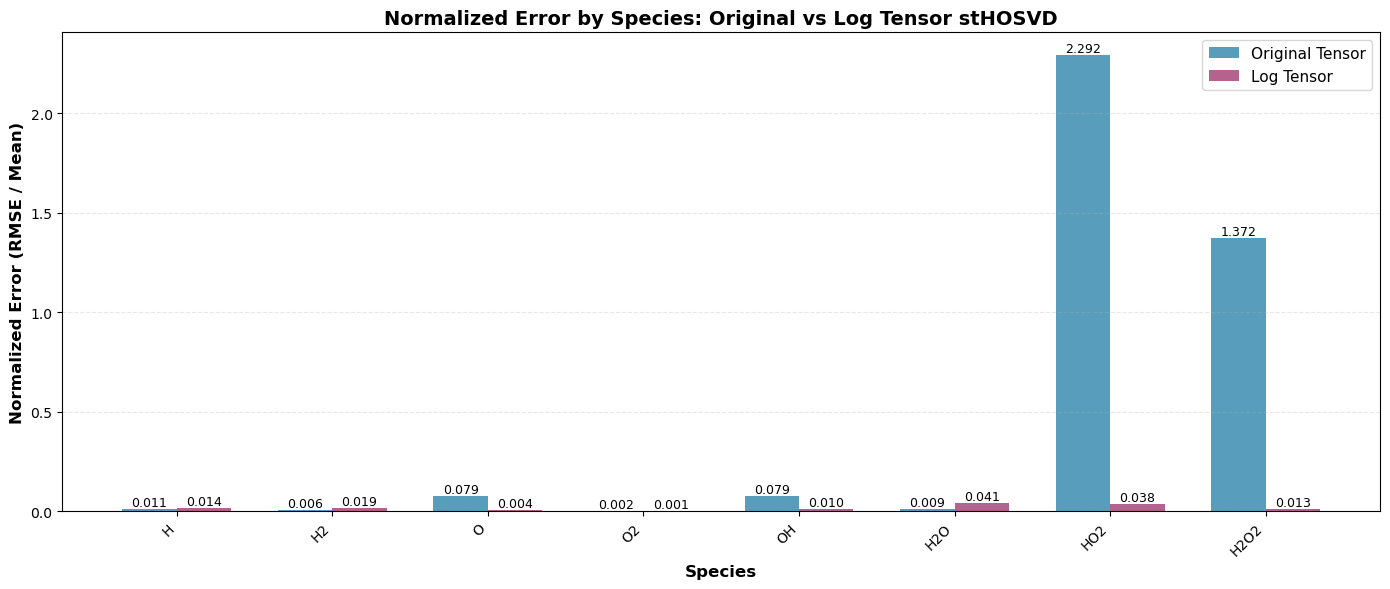

In [28]:
# Compute normalized errors by species
print("\n" + "="*80)
print("NORMALIZED ERROR BY SPECIES (RMSE / Mean per species)")
print("="*80)

# Compute for original tensor reconstruction
overall_error_orig, per_species_errors_orig = compute_error_normalized_by_species(
    tensor_combustion, reconstruction_st_orig, species_axis=2
)

# Compute for log tensor reconstruction
overall_error_log, per_species_errors_log = compute_error_normalized_by_species(
    tensor_combustion, reconstruction_st_log, species_axis=2
)

print(f"\n{'Species':<10} {'Original Tensor':<20} {'Log Tensor':<20} {'Improvement':<15}")
print("-"*80)
for species_idx in range(n_species):
    improvement = (per_species_errors_orig[species_idx] - per_species_errors_log[species_idx]) / per_species_errors_orig[species_idx] * 100
    print(f"{species_names[species_idx]:<10} {per_species_errors_orig[species_idx]:<20.6f} "
          f"{per_species_errors_log[species_idx]:<20.6f} {improvement:>+13.2f}%")

print("-"*80)
print(f"{'OVERALL':<10} {overall_error_orig:<20.6f} {overall_error_log:<20.6f} "
      f"{(overall_error_orig - overall_error_log)/overall_error_orig * 100:>+13.2f}%")
print("="*80)

# Create bar plot comparison
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(n_species)
width = 0.35

bars1 = ax.bar(x - width/2, per_species_errors_orig, width, 
               label='Original Tensor', color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x + width/2, per_species_errors_log, width, 
               label='Log Tensor', color='#A23B72', alpha=0.8)

ax.set_xlabel('Species', fontsize=12, fontweight='bold')
ax.set_ylabel('Normalized Error (RMSE / Mean)', fontsize=12, fontweight='bold')
ax.set_title('Normalized Error by Species: Original vs Log Tensor stHOSVD', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(species_names, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

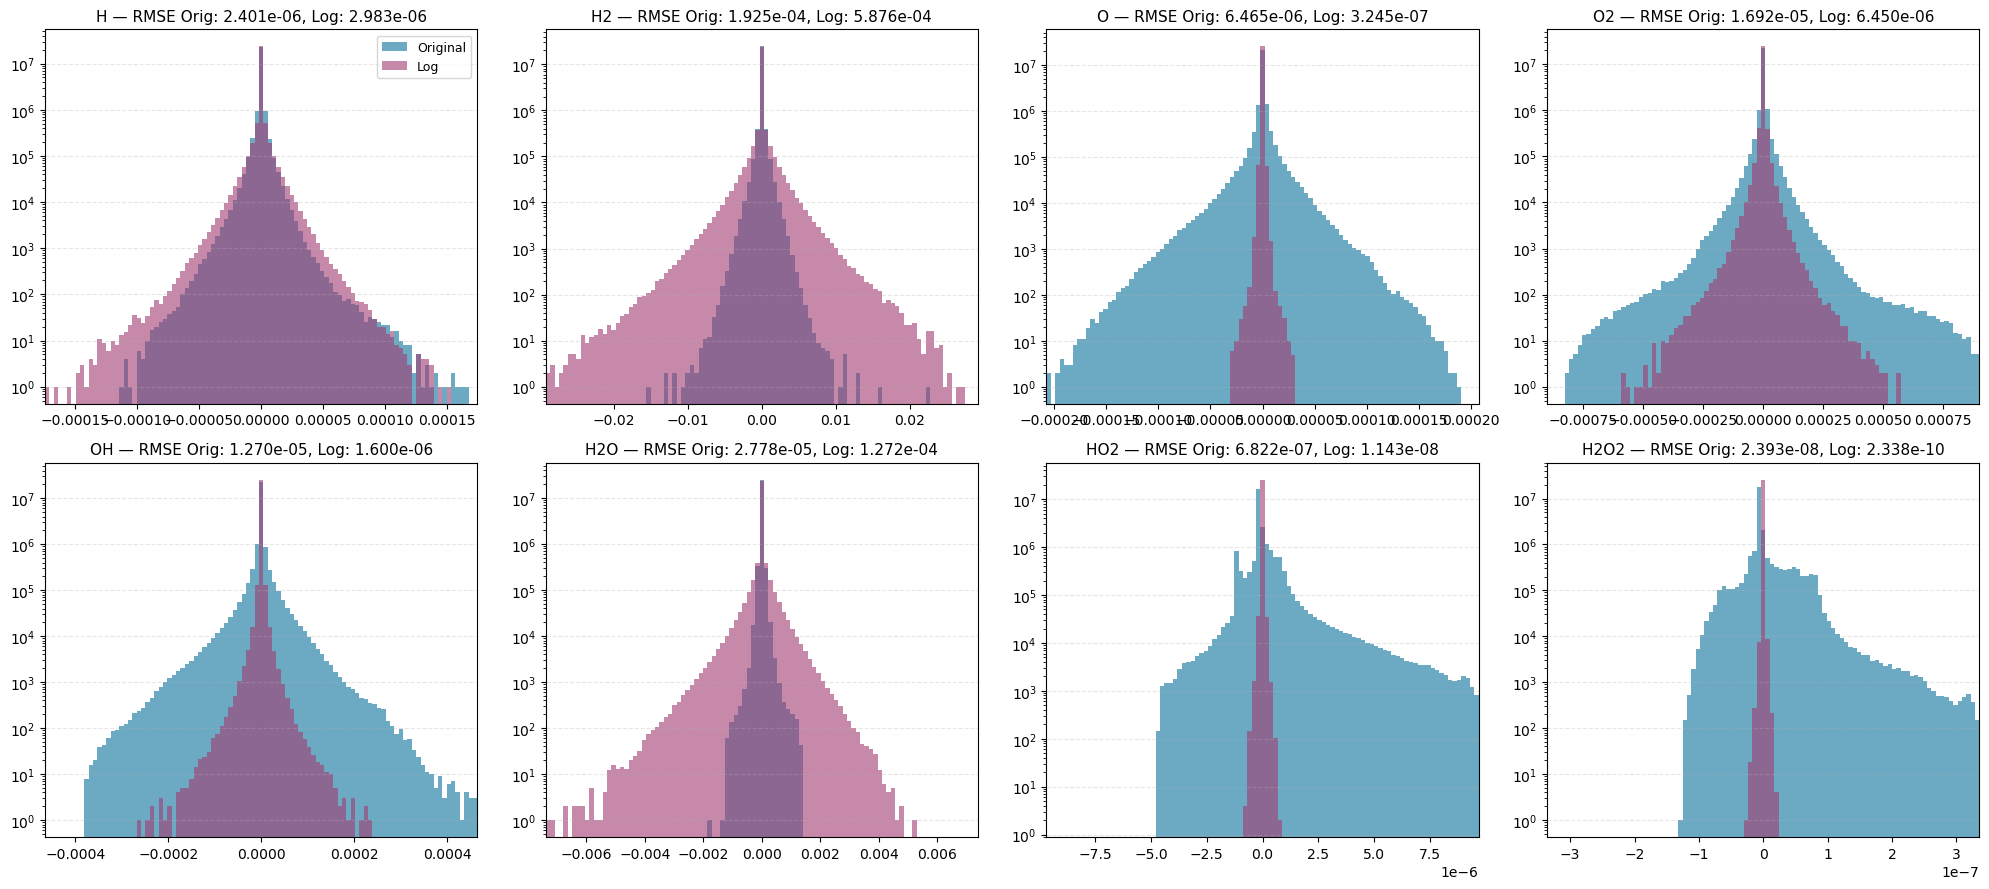

H      | Orig max: 1.650e-04, mean: 1.032e-11 | Log max: 1.745e-04, mean: -1.949e-09
H2     | Orig max: 2.253e-02, mean: -2.578e-12 | Log max: 2.922e-02, mean: 7.192e-07
O      | Orig max: 2.073e-04, mean: 7.040e-12 | Log max: 3.013e-05, mean: -1.741e-10
O2     | Orig max: 9.005e-04, mean: 1.267e-13 | Log max: 5.902e-04, mean: -5.234e-09
OH     | Orig max: 4.648e-04, mean: 2.581e-11 | Log max: 2.637e-04, mean: -2.460e-09
H2O    | Orig max: 1.783e-03, mean: 1.397e-10 | Log max: 7.389e-03, mean: -3.881e-07
HO2    | Orig max: 9.691e-06, mean: -5.853e-10 | Log max: 7.385e-07, mean: -7.140e-11
H2O2   | Orig max: 3.357e-07, mean: -3.327e-11 | Log max: 2.387e-08, mean: -6.553e-11


In [30]:
# Plot error histograms per species (2x4 grid)
fig, axes = plt.subplots(2, 4, figsize=(20, 9))
axes = axes.ravel()

# Compute element-wise errors
error_orig = (tensor_combustion - reconstruction_st_orig)
error_log = (tensor_combustion - reconstruction_st_log)

for i in range(n_species):
    ax = axes[i]
    err_o = error_orig[:, :, i, :].ravel()
    err_l = error_log[:, :, i, :].ravel()

    # Determine symmetric range around zero for bins
    vmin = min(err_o.min(), err_l.min())
    vmax = max(err_o.max(), err_l.max())
    maxabs = max(abs(vmin), abs(vmax)) if (vmin != vmax) else max(abs(vmin), 1e-8)
    bins = np.linspace(-maxabs, maxabs, 100)

    # Plot histograms (overlayed)
    ax.hist(err_o, bins=bins, color='#2E86AB', alpha=0.7, label='Original')
    ax.hist(err_l, bins=bins, color='#A23B72', alpha=0.6, label='Log')

    # Compute RMSEs for the legend/title
    rmse_o = np.sqrt(np.mean(err_o**2))
    rmse_l = np.sqrt(np.mean(err_l**2))

    ax.set_title(f"{species_names[i]} — RMSE Orig: {rmse_o:.3e}, Log: {rmse_l:.3e}", fontsize=11)
    ax.set_yscale('log')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_xlim(-maxabs, maxabs)

    if i == 0:
        ax.legend(fontsize=9)

# Turn off any unused subplots (in case n_species < 8)
for ax in axes[n_species:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print summary statistics
for i in range(n_species):
    err_o = error_orig[:, :, i, :].ravel()
    err_l = error_log[:, :, i, :].ravel()
    print(f"{species_names[i]:<6} | Orig max: {np.max(np.abs(err_o)):.3e}, mean: {np.mean(err_o):.3e} | Log max: {np.max(np.abs(err_l)):.3e}, mean: {np.mean(err_l):.3e}")

Computing global color scales for each species...
Species H: vmax = 3.709862e-03
Species H2: vmax = 8.893419e-02
Species O: vmax = 1.725601e-03
Species O2: vmax = 3.091853e-03
Species OH: vmax = 2.227399e-03
Species H2O: vmax = 2.598688e-02
Species HO2: vmax = 1.030308e-05
Species H2O2: vmax = 7.385385e-07


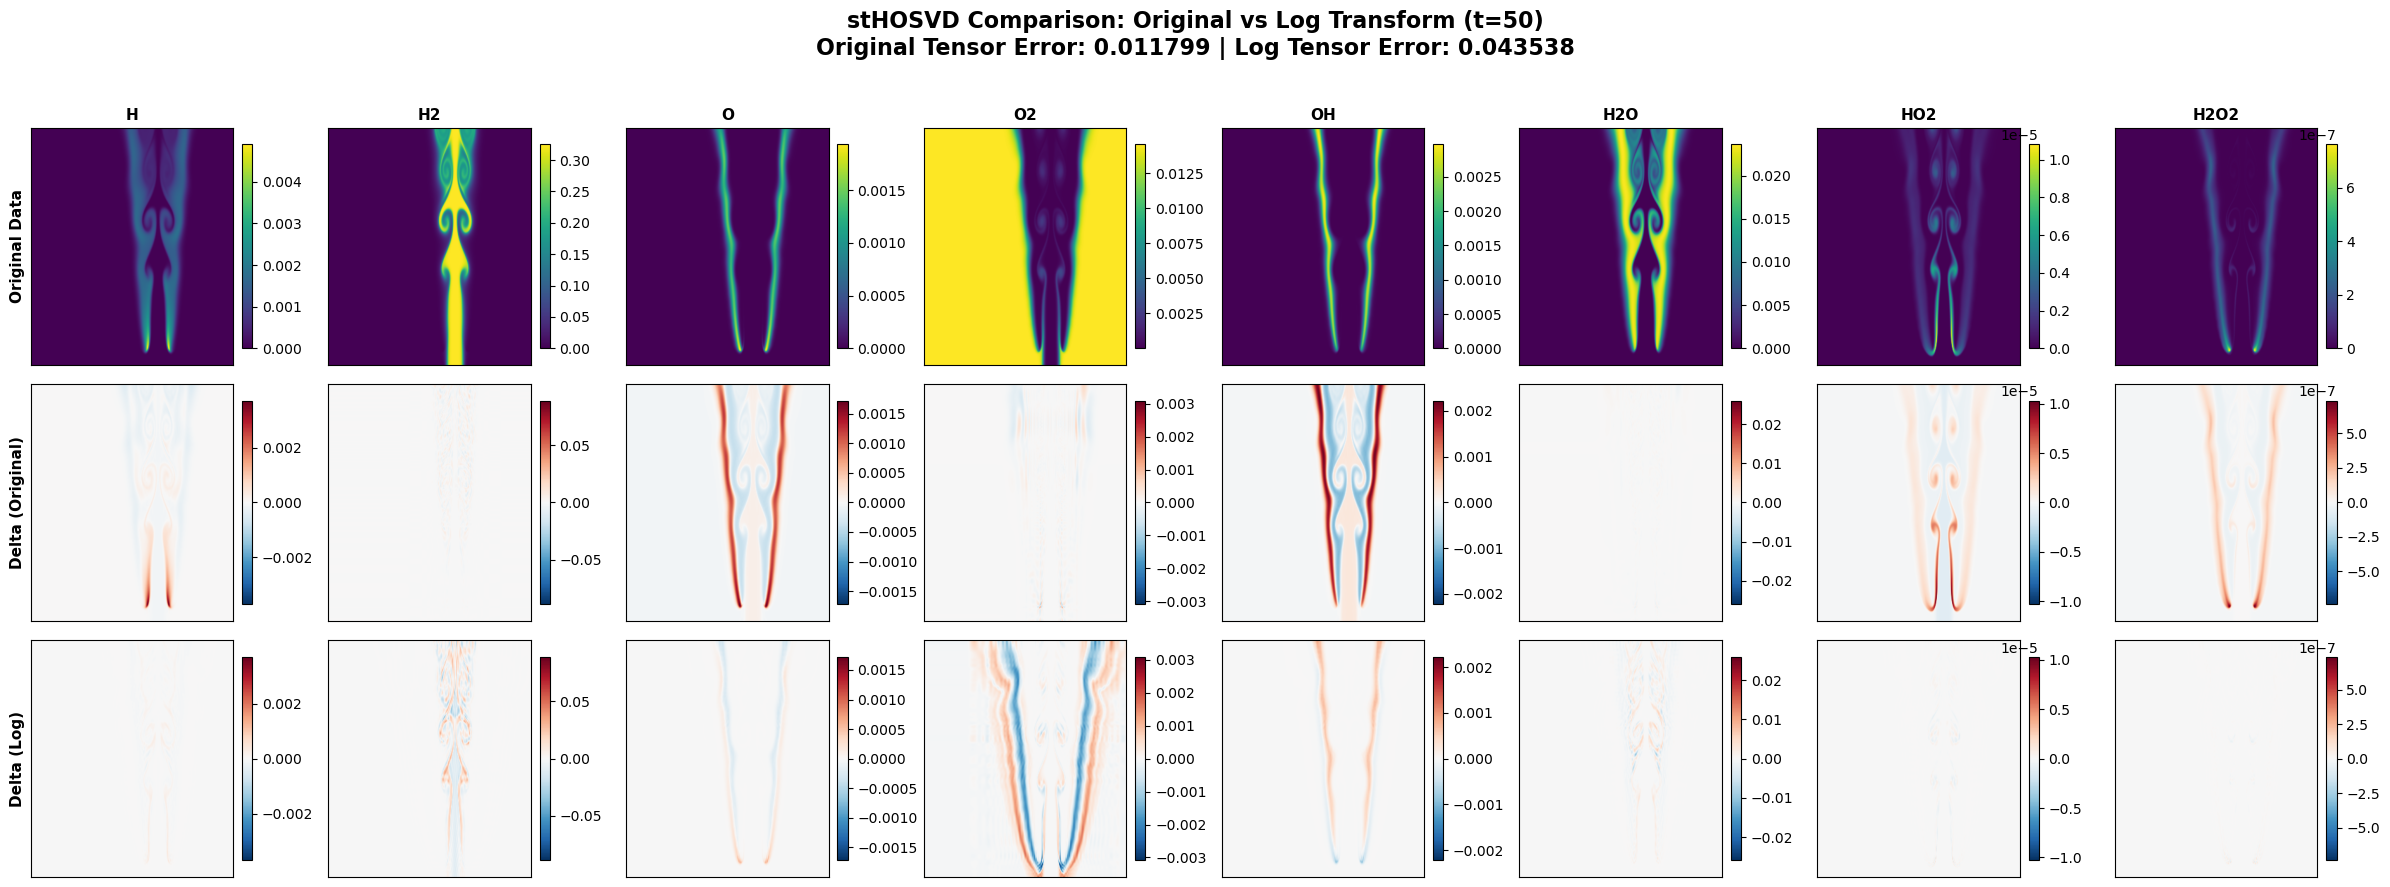


Error Statistics by Species:
Species    Original RMSE        Log RMSE            
--------------------------------------------------------------------------------
H          1.898643e-04         2.790368e-05        
H2         9.220882e-04         3.874138e-03        
O          2.461596e-04         4.533944e-05        
O2         6.444028e-05         4.551088e-04        
OH         4.236163e-04         1.114934e-04        
H2O        1.090325e-04         5.678703e-04        
HO2        7.810968e-07         5.885313e-08        
H2O2       4.830190e-08         2.486744e-09        


In [ ]:
# Create 3x8 subplot visualization for all species at time step 0
time_idx = 50
n_species = 8

# Pre-compute global color scales for each species across all timesteps
print("Computing global color scales for each species...")
vmax_per_species = []
for species_idx in range(n_species):
    # Compute deltas for all timesteps
    delta_orig_all = tensor_combustion[:, :, species_idx, :] - reconstruction_st_orig[:, :, species_idx, :]
    delta_log_all = tensor_combustion[:, :, species_idx, :] - reconstruction_st_log[:, :, species_idx, :]
    
    # Get the max absolute value across both deltas and all timesteps
    vmax = max(np.max(np.abs(delta_orig_all)), np.max(np.abs(delta_log_all)))
    vmax_per_species.append(vmax)
    print(f"Species {species_names[species_idx]}: vmax = {vmax:.6e}")

fig, axes = plt.subplots(3, n_species, figsize=(24, 9))

# Add main title with error information
fig.suptitle(f'stHOSVD Comparison: Original vs Log Transform (t={time_idx})\n' +
             f'Original Tensor Error: {error_st_orig:.6f} | Log Tensor Error: {error_st_log:.6f}',
             fontsize=16, fontweight='bold', y=0.98)

for species_idx in range(n_species):
    # Get data for this species at time step 0
    original = tensor_combustion[:, :, species_idx, time_idx]
    reconstructed_orig = reconstruction_st_orig[:, :, species_idx, time_idx]
    reconstructed_log = reconstruction_st_log[:, :, species_idx, time_idx]
    
    # Compute deltas
    delta_orig = original - reconstructed_orig
    delta_log = original - reconstructed_log
    
    # Use pre-computed global vmax for this species
    vmax = vmax_per_species[species_idx]
    
    # Row 1: Original data
    ax1 = axes[0, species_idx]
    im1 = ax1.imshow(original, cmap='viridis', aspect='auto', origin='lower')
    ax1.set_title(f'{species_names[species_idx]}', fontsize=11, fontweight='bold')
    if species_idx == 0:
        ax1.set_ylabel('Original Data', fontsize=11, fontweight='bold')
    ax1.set_xticks([])
    ax1.set_yticks([])
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    
    # Row 2: Delta (original - reconstructed from original tensor)
    ax2 = axes[1, species_idx]
    im2 = ax2.imshow(delta_orig, cmap='RdBu_r', aspect='auto', origin='lower', 
                     vmin=-vmax, vmax=vmax)
    if species_idx == 0:
        ax2.set_ylabel('Delta (Original)', fontsize=11, fontweight='bold')
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    # Row 3: Delta (original - reconstructed from log tensor)
    ax3 = axes[2, species_idx]
    im3 = ax3.imshow(delta_log, cmap='RdBu_r', aspect='auto', origin='lower',
                     vmin=-vmax, vmax=vmax)
    if species_idx == 0:
        ax3.set_ylabel('Delta (Log)', fontsize=11, fontweight='bold')
    ax3.set_xticks([])
    ax3.set_yticks([])
    plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Print statistics for each species
print("\nError Statistics by Species:")
print("="*80)
print(f"{'Species':<10} {'Original RMSE':<20} {'Log RMSE':<20}")
print("-"*80)
for species_idx in range(n_species):
    orig_slice = tensor_combustion[:, :, species_idx, :]
    recon_orig_slice = reconstruction_st_orig[:, :, species_idx, :]
    recon_log_slice = reconstruction_st_log[:, :, species_idx, :]
    
    rmse_orig = np.sqrt(np.mean((orig_slice - recon_orig_slice)**2))
    rmse_log = np.sqrt(np.mean((orig_slice - recon_log_slice)**2))
    
    print(f"{species_names[species_idx]:<10} {rmse_orig:<20.6e} {rmse_log:<20.6e}")
print("="*80)

Creating animated GIF...
Total frames: 200
Saving animation to stHOSVD_comparison_animation.gif...


KeyboardInterrupt: 

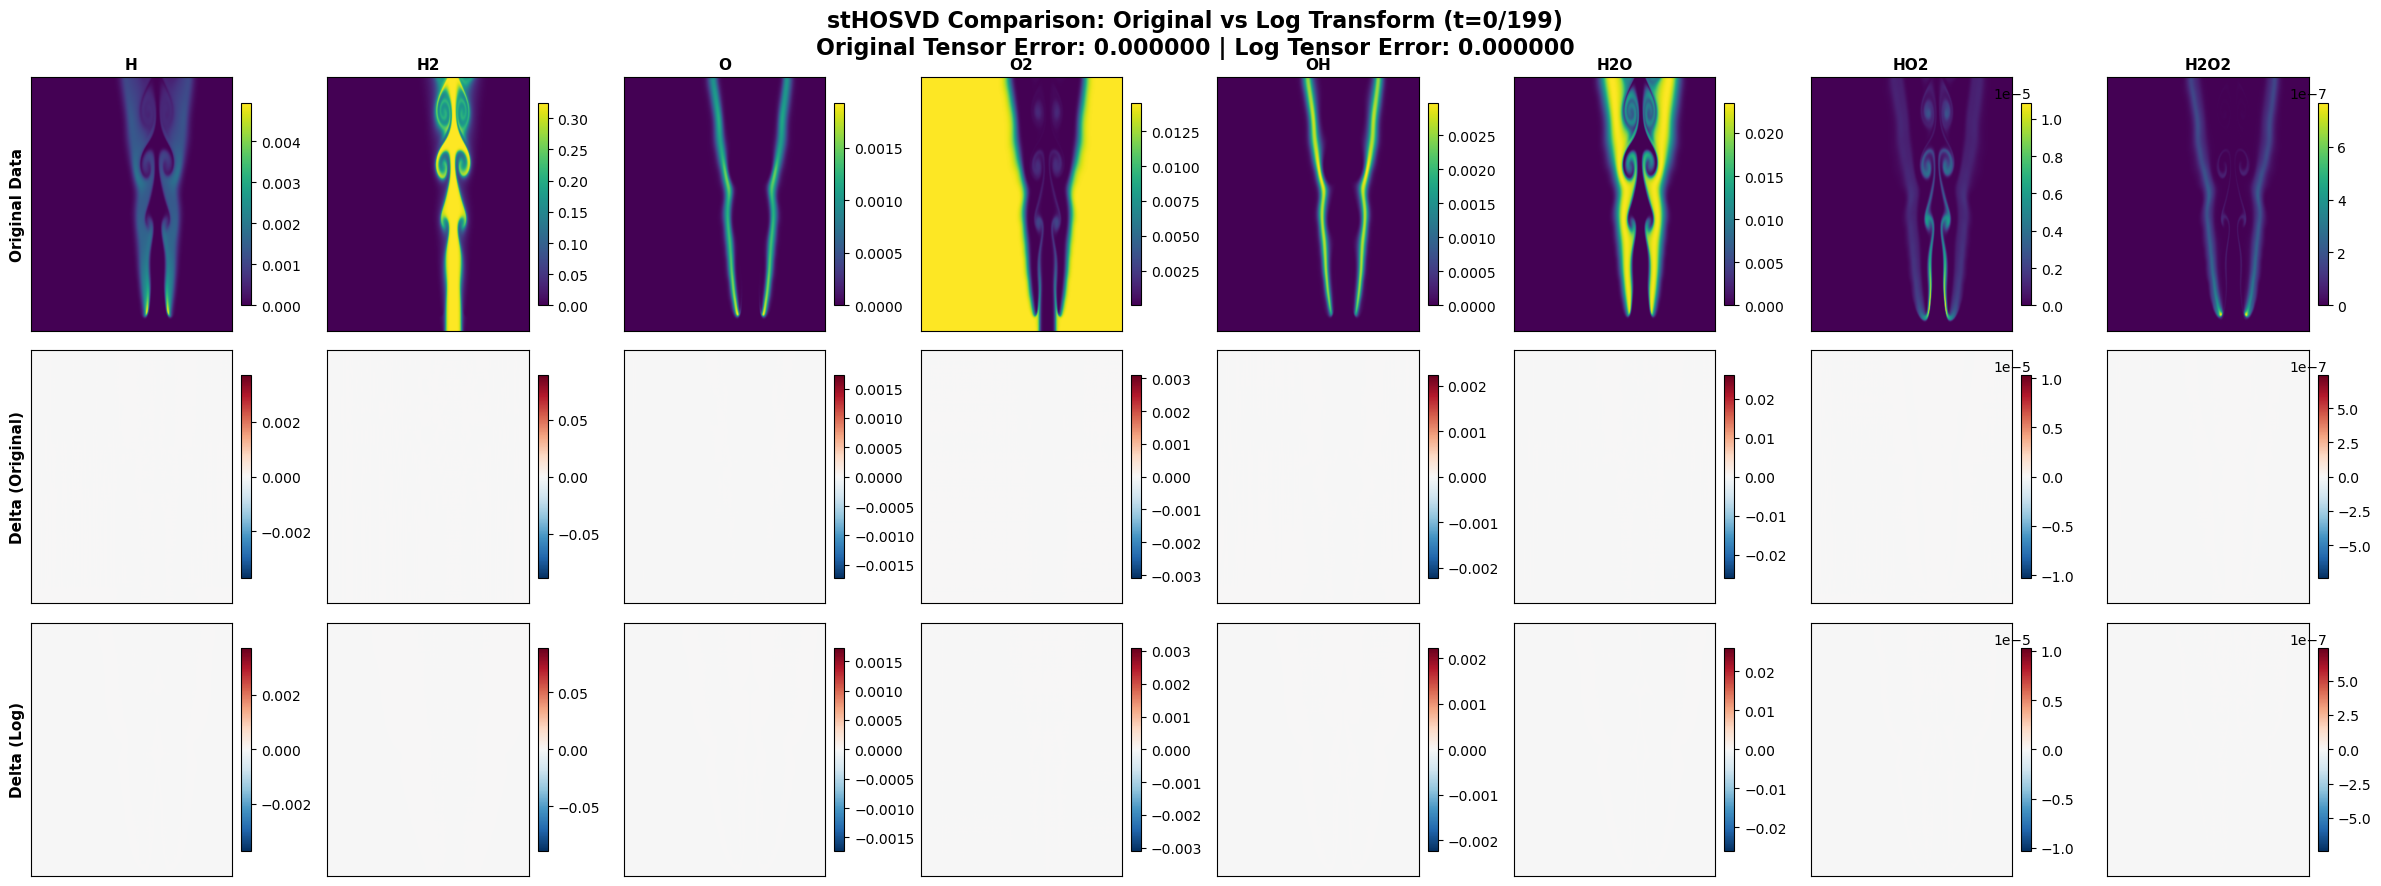

In [22]:
# Create animated GIF showing all time steps
from matplotlib.animation import FuncAnimation, PillowWriter

print("Creating animated GIF...")
print(f"Total frames: {n_snapshots}")

# Pre-compute global color scales for each species across all timesteps
# (reuse from previous cell if already computed)
if 'vmax_per_species' not in locals():
    print("Computing global color scales for each species...")
    vmax_per_species = []
    for species_idx in range(n_species):
        # Compute deltas for all timesteps
        delta_orig_all = tensor_combustion[:, :, species_idx, :] - reconstruction_st_orig[:, :, species_idx, :]
        delta_log_all = tensor_combustion[:, :, species_idx, :] - reconstruction_st_log[:, :, species_idx, :]
        
        # Get the max absolute value across both deltas and all timesteps
        vmax = max(np.max(np.abs(delta_orig_all)), np.max(np.abs(delta_log_all)))
        vmax_per_species.append(vmax)
        print(f"Species {species_names[species_idx]}: vmax = {vmax:.6e}")

# Create figure and axes
fig, axes = plt.subplots(3, n_species, figsize=(24, 9))

# Initialize image objects for each subplot
images = []
for species_idx in range(n_species):
    row_images = []
    for row_idx in range(3):
        ax = axes[row_idx, species_idx]
        if row_idx == 0:
            im = ax.imshow(np.zeros((tensor_combustion.shape[0], tensor_combustion.shape[1])), 
                          cmap='viridis', aspect='auto', origin='lower')
        else:
            im = ax.imshow(np.zeros((tensor_combustion.shape[0], tensor_combustion.shape[1])), 
                          cmap='RdBu_r', aspect='auto', origin='lower',
                          vmin=-vmax_per_species[species_idx], vmax=vmax_per_species[species_idx])
        row_images.append(im)
        
        # Set labels and titles
        if row_idx == 0:
            ax.set_title(f'{species_names[species_idx]}', fontsize=11, fontweight='bold')
        if species_idx == 0:
            if row_idx == 0:
                ax.set_ylabel('Original Data', fontsize=11, fontweight='bold')
            elif row_idx == 1:
                ax.set_ylabel('Delta (Original)', fontsize=11, fontweight='bold')
            else:
                ax.set_ylabel('Delta (Log)', fontsize=11, fontweight='bold')
        
        ax.set_xticks([])
        ax.set_yticks([])
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    images.append(row_images)

# Main title
title = fig.suptitle('', fontsize=16, fontweight='bold', y=0.98)

# Animation update function
def update(frame):
    time_idx = frame
    
    # Update title
    title.set_text(f'stHOSVD Comparison: Original vs Log Transform (t={time_idx}/{n_snapshots-1})\n' +
                   f'Original Tensor Error: {error_st_orig:.6f} | Log Tensor Error: {error_st_log:.6f}')
    
    for species_idx in range(n_species):
        # Get data for this species at current time step
        original = tensor_combustion[:, :, species_idx, time_idx]
        reconstructed_orig = reconstruction_st_orig[:, :, species_idx, time_idx]
        reconstructed_log = reconstruction_st_log[:, :, species_idx, time_idx]
        
        # Compute deltas
        delta_orig = original - reconstructed_orig
        delta_log = original - reconstructed_log
        
        # Update row 1: Original data
        images[species_idx][0].set_array(original)
        images[species_idx][0].set_clim(vmin=original.min(), vmax=original.max())
        
        # Update row 2: Delta (original) - using fixed global scale
        images[species_idx][1].set_array(delta_orig)
        # clim already set during initialization, no need to update
        
        # Update row 3: Delta (log) - using fixed global scale
        images[species_idx][2].set_array(delta_log)
        # clim already set during initialization, no need to update
    
    return [img for row in images for img in row] + [title]

plt.tight_layout(rect=[0, 0, 1, 0.96])

# Create animation
anim = FuncAnimation(fig, update, frames=n_snapshots, interval=100, blit=False)

# Save as GIF
output_filename = 'stHOSVD_comparison_animation.gif'
print(f"Saving animation to {output_filename}...")
writer = PillowWriter(fps=10)
anim.save(output_filename, writer=writer)
print(f"Animation saved successfully!")

plt.close()

# Display a preview of a few frames
print(f"\nAnimation created with {n_snapshots} frames at 10 FPS")
print(f"Duration: {n_snapshots/10:.1f} seconds")
print(f"File saved as: {output_filename}")

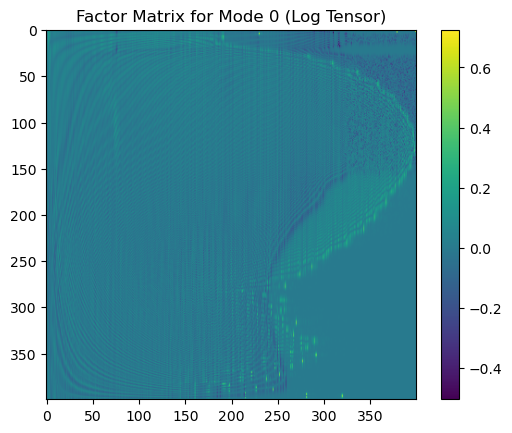

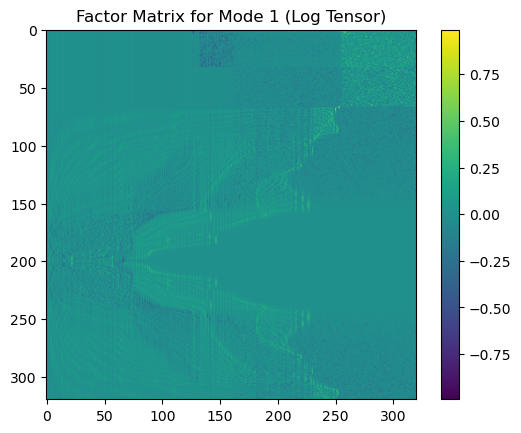

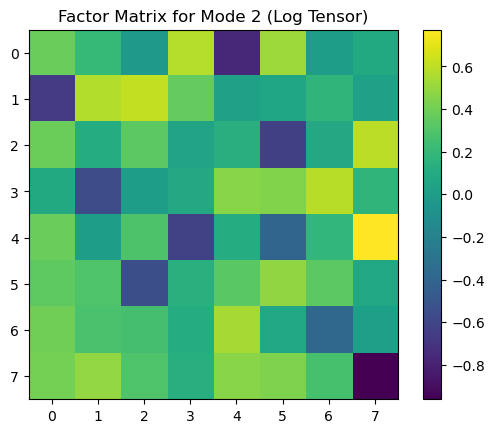

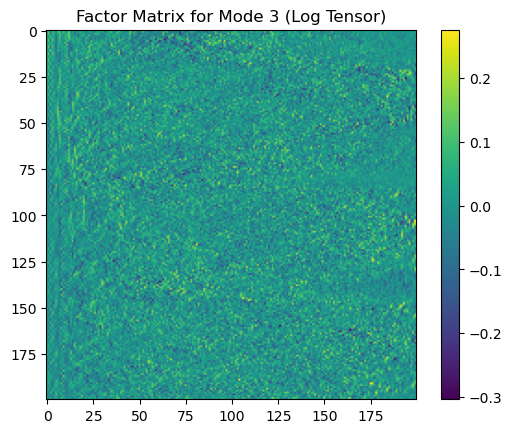

<Figure size 640x480 with 0 Axes>

In [24]:
for idx, f in enumerate(factors_st):
    plt.imshow(np.subtract(np.abs(factors_st_log[idx]), np.abs(factors_st_orig[idx])))
    plt.title(f"Factor Matrix for Mode {idx} (Log Tensor)")
    plt.colorbar()
    
    
    plt.figure()